In [1]:
# Step: Load Required Libraries
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Step: Load the Trained Model
model = tf.keras.models.load_model('../models/model.keras')

# Load the scalers
scaler_features = joblib.load('../models/scaler_features.pkl')
scaler_target = joblib.load('../models/scaler_target.pkl')

print('Successfully loaded!')

Successfully loaded!


In [6]:
# Step: Load and Preprocess Kline Features
df_features = pd.read_csv(f'../features/merged/BTCUSDT/features.csv')

# Define Kline Features
features = df_features[[
  'features_kline_openPrice', 'features_kline_highPrice', 'features_kline_lowPrice', 'features_kline_closePrice', 'features_kline_volume', 'features_kline_turnover', 'features_kline_priceChange', 'features_kline_logReturn', 'features_kline_SMA_5', 'features_kline_SMA_10', 'features_kline_EMA_5', 'features_kline_EMA_10', 'features_kline_hourOfDay', 'features_kline_dayOfWeek', 'features_kline_weekOfYear', 'features_kline_monthOfYear', 'features_kline_minuteOfHour', 'features_kline_isWeekend', 'features_kline_highLowRange', 'features_kline_stdReturn_5m', 'features_kline_stdReturn_10m', 'features_kline_RSI_14', 'features_kline_MACD_line', 'features_kline_MACD_signal', 'features_kline_MACD_histogram', 'features_kline_Stochastic_K', 'features_kline_Stochastic_D', 'features_kline_ROC_14',
  'features_mark_price_kline_openPrice', 'features_mark_price_kline_highPrice', 'features_mark_price_kline_lowPrice', 'features_mark_price_kline_closePrice', 'features_mark_price_kline_priceChange', 'features_mark_price_kline_logReturn', 'features_mark_price_kline_SMA_5', 'features_mark_price_kline_SMA_10', 'features_mark_price_kline_EMA_5', 'features_mark_price_kline_EMA_10', 'features_mark_price_kline_highLowRange', 'features_mark_price_kline_stdReturn_5m', 'features_mark_price_kline_stdReturn_10m', 'features_mark_price_kline_RSI_14', 'features_mark_price_kline_MACD_line', 'features_mark_price_kline_MACD_signal', 'features_mark_price_kline_MACD_histogram', 'features_mark_price_kline_Stochastic_K', 'features_mark_price_kline_Stochastic_D', 'features_mark_price_kline_ROC_14',
  'features_index_price_kline_openPrice', 'features_index_price_kline_highPrice', 'features_index_price_kline_lowPrice', 'features_index_price_kline_closePrice', 'features_index_price_kline_priceChange', 'features_index_price_kline_logReturn', 'features_index_price_kline_SMA_5', 'features_index_price_kline_SMA_10', 'features_index_price_kline_EMA_5', 'features_index_price_kline_EMA_10', 'features_index_price_kline_highLowRange', 'features_index_price_kline_stdReturn_5m', 'features_index_price_kline_stdReturn_10m', 'features_index_price_kline_RSI_14', 'features_index_price_kline_MACD_line', 'features_index_price_kline_MACD_signal', 'features_index_price_kline_MACD_histogram', 'features_index_price_kline_Stochastic_K', 'features_index_price_kline_Stochastic_D', 'features_index_price_kline_ROC_14',

  'features_premium_index_price_kline_openPrice', 'features_premium_index_price_kline_highPrice', 'features_premium_index_price_kline_lowPrice', 'features_premium_index_price_kline_closePrice', 'features_premium_index_price_kline_priceChange', 'features_premium_index_price_kline_logReturn', 'features_premium_index_price_kline_SMA_5', 'features_premium_index_price_kline_SMA_10', 'features_premium_index_price_kline_EMA_5', 'features_premium_index_price_kline_EMA_10', 'features_premium_index_price_kline_highLowRange', 'features_premium_index_price_kline_stdReturn_5m', 'features_premium_index_price_kline_stdReturn_10m', 'features_premium_index_price_kline_RSI_14', 'features_premium_index_price_kline_MACD_line', 'features_premium_index_price_kline_MACD_signal', 'features_premium_index_price_kline_MACD_histogram', 'features_premium_index_price_kline_Stochastic_K', 'features_premium_index_price_kline_Stochastic_D', 'features_premium_index_price_kline_ROC_14', 
    
  'features_funding_rate_fundingRate', 
  # 'features_funding_rate_fundingRateMean_5m', 
  # 'features_funding_rate_fundingRateMean_10m', 
  # 'features_funding_rate_fundingRateVolatility_5m', 
  # 'features_funding_rate_fundingRateVolatility_10m', 
  'features_funding_rate_cumulativeFundingRate', 
  'features_funding_rate_fundingRateChange', 
  'features_funding_rate_fundingRateROC', 
  'features_funding_rate_sentiment', 
  'features_funding_rate_fundingRateLag1',
    
  'features_long_short_ratio_buyRatio', 
  'features_long_short_ratio_sellRatio', 
  'features_long_short_ratio_net_position', 
  'features_long_short_ratio_long_short_ratio', 
  'features_long_short_ratio_buyRatio_rolling_avg_15min', 
  'features_long_short_ratio_sellRatio_rolling_avg_15min', 
  'features_long_short_ratio_buyRatio_rolling_avg_30min', 
  'features_long_short_ratio_sellRatio_rolling_avg_30min', 
  'features_long_short_ratio_buyRatio_rolling_std_15min', 
  'features_long_short_ratio_sellRatio_rolling_std_15min', 
  'features_long_short_ratio_buyRatio_rolling_std_30min', 
  'features_long_short_ratio_sellRatio_rolling_std_30min', 
  'features_long_short_ratio_buyRatio_roc_5min', 
  'features_long_short_ratio_sellRatio_roc_5min', 
  'features_long_short_ratio_buyRatio_roc_15min', 
  'features_long_short_ratio_sellRatio_roc_15min', 
  'features_long_short_ratio_buyRatio_roc_30min', 
  'features_long_short_ratio_sellRatio_roc_30min', 
  'features_long_short_ratio_sentiment_class', 
  'features_long_short_ratio_sentiment_strength', 
  'features_long_short_ratio_buyRatio_lag_1', 
  'features_long_short_ratio_sellRatio_lag_1', 
  'features_long_short_ratio_extreme_buy_ratio', 
  'features_long_short_ratio_extreme_sell_ratio',
  'features_long_short_ratio_corr_long_short_price_5min',
  'features_long_short_ratio_corr_long_short_price_10min',
    
  'features_open_interest_openInterest', 
  'features_open_interest_oi_rolling_avg_15min', 
  'features_open_interest_oi_rolling_std_15min', 
  'features_open_interest_oi_rolling_avg_30min', 
  'features_open_interest_oi_rolling_std_30min', 
  'features_open_interest_oi_pct_change', 
  'features_open_interest_oi_rate_of_change_5min', 
  'features_open_interest_cumulative_open_interest', 
  'features_open_interest_cumulative_pct_change_oi', 
  'features_open_interest_oi_momentum_15min', 
  'features_open_interest_oi_momentum_30min', 
  'features_open_interest_oi_sentiment',
  'features_open_interest_oi_to_price_ratio',
  'features_open_interest_price_vs_oi_divergence',

  'features_order_book_mid_price_mean', 'features_order_book_mid_price_std', 'features_order_book_mid_price_min', 'features_order_book_mid_price_max', 'features_order_book_mid_price_last', 'features_order_book_spread_mean', 'features_order_book_spread_std', 'features_order_book_spread_max', 'features_order_book_relative_spread_mean', 'features_order_book_relative_spread_std', 'features_order_book_total_best_ask_volume_mean', 'features_order_book_total_best_ask_volume_std', 'features_order_book_total_best_ask_volume_sum', 'features_order_book_total_best_ask_volume_max', 'features_order_book_total_best_bid_volume_mean', 'features_order_book_total_best_bid_volume_std', 'features_order_book_total_best_bid_volume_sum', 'features_order_book_total_best_bid_volume_max', 'features_order_book_market_depth_ask_mean', 'features_order_book_market_depth_ask_std', 'features_order_book_market_depth_bid_mean', 'features_order_book_market_depth_bid_std', 'features_order_book_order_book_imbalance_mean', 'features_order_book_order_book_imbalance_std', 'features_order_book_vwap_ask_mean', 'features_order_book_vwap_bid_mean', 'features_order_book_vwap_total_mean', 'features_order_book_volume_imbalance_ratio_mean', 'features_order_book_volume_imbalance_ratio_std', 'features_order_book_cumulative_delta_volume_last', 'features_order_book_liquidity_pressure_ratio_mean', 'features_order_book_liquidity_pressure_ratio_std', 'features_order_book_mean_ask_size_mean', 'features_order_book_mean_ask_size_std', 'features_order_book_mean_bid_size_mean', 'features_order_book_mean_bid_size_std', 'features_order_book_std_ask_size_mean', 'features_order_book_std_bid_size_mean', 'features_order_book_realized_volatility'
]]

# Define Target (Next Close Price)
target = features['features_kline_closePrice'].shift(-1)  # Shift by 1 to predict the next closePrice
target = target.iloc[:-1]  # Drop the last row from target to match features size
features = features.iloc[:-1]  # Drop the last row from features to match target size
  
features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
features.fillna(0, inplace=True)

# Scale the features
features_scaled = scaler_features.fit_transform(features)

# Scale the target (closePrice)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [7]:
# Step: Make Predictions
y_pred_scaled = model.predict(features_scaled)
y_pred = scaler_target.inverse_transform(y_pred_scaled)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [8]:
# Step: Model Evaluation
mse = mean_squared_error(target, y_pred)
mae = mean_absolute_error(target, y_pred)

print(f'Model Evaluation Metrics:')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Model Evaluation Metrics:
Mean Squared Error (MSE): 1370.7640249001975
Mean Absolute Error (MAE): 27.422271107456094


In [9]:
# Step: Calculate diff sign error

# 1) Calculate the difference between adjacent actual and predicted close prices
actual_diff = np.diff(target)  # Difference between adjacent actual close prices
predicted_diff = np.diff(y_pred.flatten())  # Difference between adjacent predicted close prices

# 2) Calculate the sign of the actual and predicted differences
actual_sign = np.sign(actual_diff)
predicted_sign = np.sign(predicted_diff)

# 4) Compare the signs and count how many times they are the same
same_sign_count = np.sum(actual_sign == predicted_sign)

# Print the results
print(f"Number of times the signs are the same: {same_sign_count} of {len(actual_sign)}")

Number of times the signs are the same: 617 of 1139


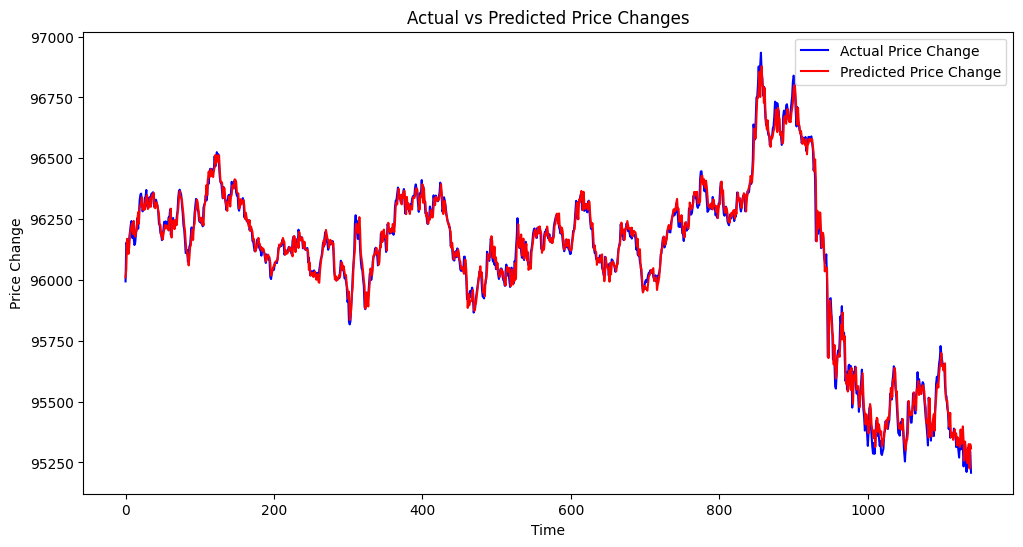

In [10]:
# Step: Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(target.values, label='Actual Price Change', color='blue')
plt.plot(y_pred, label='Predicted Price Change', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.title('Actual vs Predicted Price Changes')
plt.show()

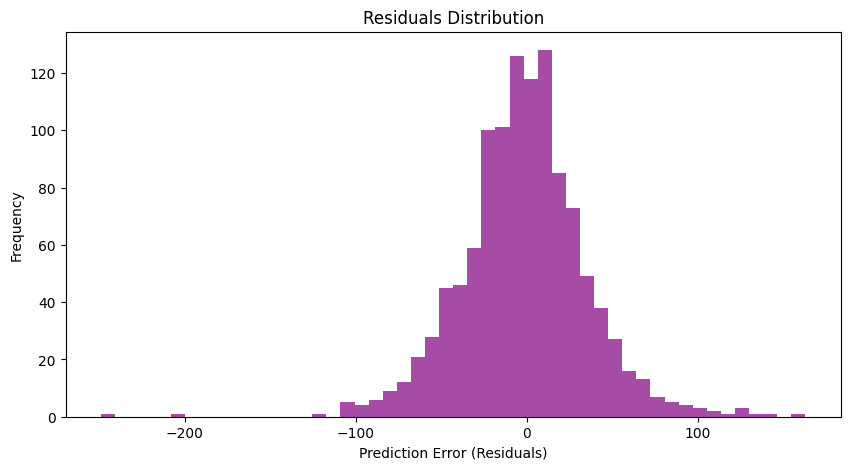

In [11]:
# Step: Error Analysis (Residual Plot)
residuals = target.values - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Residuals)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()